_This notebook contains code and comments from Section 9.1 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---
## 9.1	What is Interpretability?
The notions of interpretability and explainability of a machine-learning model are related to its structure (e.g., is it a tree, a network, a linear model?) and its parameters (e.g., split and leaf values in trees, layer weights in neural networks, feature weights in linear models).

### 9.1.1	Black-Box vs. Glass-Box Models  
_Black-box machine-learning models_ are models that are difficult to describe in terms of their model internals. This can be because we do not have access to the internal model structure and parameters (for example, if it was trained by someone else). Even in cases where we do have access to the model internals, the model itself may be sufficiently complex that it is not easy to analyze and establish an intuitive understanding of the relationship between its inputs and outputs.

_Glass-box machine-learning models_, on the other hand, are easier to understand. This is often because their model structures are immediately intuitive or comprehensible to humans.

For example, consider a simple task of diabetes diagnosis   from only two features: age and blood-glucose test result (glc). Patients who do not have diabetes (class=-1) are denoted by squares and patients who have diabetes (class=+1) are denoted by circles. We illustrate two two machine-learning models that have identical predictive performance, a 4-th degree polynomial classifier (a black box) and a decision tree classifier (a glass box). 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

[ 2.21355551e-03 -4.97317107e-01  4.17338703e+01 -1.55025156e+03
  2.16456473e+04]


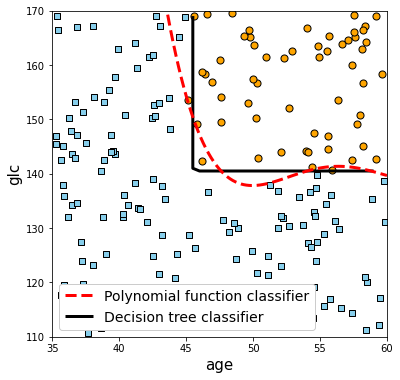

In [2]:
# Source code to generate Figure 9.2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
cmap = ListedColormap(['#b30065', '#178000'])

# Create a mesh
xMin, xMax = 30, 60
yMin, yMax = 110, 170
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 1), 
                           np.arange(yMin, yMax, 1))

# Create a decision rule "age > 45 AND glc > 140 -> diabetes = 1 else diabetes = -1
def decision_rule(X, a=45, b=140):
    return 2*((X[:, 0] > 45) & (X[:, 1] > 140)).astype(float) - 1

# Scatter some training examples
n = 200
x = np.random.uniform(low=35, high=60, size=(n, ))
y = np.random.uniform(low=110, high=170, size=(n, ))
z = decision_rule(np.column_stack([x, y]), a=42, b=135)
ax.scatter(x[z>0], y[z>0], c='orange', marker='o', s=50, edgecolor='k')
ax.scatter(x[z<0], y[z<0], c='skyblue', marker='s', s=40, edgecolor='k')

# Plot contours
zMesh = decision_rule(np.c_[xMesh.ravel(), yMesh.ravel()])
zMesh = zMesh.reshape(xMesh.shape)
# ax.contourf(xMesh, yMesh, zMesh, cmap=plt.cm.PiYG, alpha=0.3)
cs = ax.contour(xMesh, yMesh, zMesh, colors='k', levels=[0], alpha=1, linestyles=['-'], linewidths=[3])
cs.collections[0].set_label('Decision tree classifier')
ax.set_xlabel('age', fontsize=15)
ax.set_ylabel('glc', fontsize=15)

# Create a polynomial function to capture a similar region
n, d = 100, 4
u = np.row_stack([np.column_stack([np.linspace(45, 65, num=n), np.full((n, ), 140)]), 
                  np.column_stack([np.full((n, ), 45), np.linspace(140, 170, num=n)])])
w = np.polyfit(u[:, 0], u[:, 1], deg=d)

x = np.linspace(40, 60, num=100)
y = np.sum(np.array([w[i] * x**(d - i) for i in range(d + 1)]), axis=0)

ax.plot(x, y, linestyle='--', linewidth=3, c='r', label='Polynomial function classifier')
ax.set_xlim([35, 60])
ax.set_ylim([110, 170])
ax.legend(fancybox=True, framealpha=1., loc='lower left', fontsize=14)
print(w)

pngFile = './figures/CH09_F02_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 9.1 Decision Trees (and Decision Lists)
Decision trees are arguably the most interpretable of machine-learning models as they implement decision-making as a sequential process of asking and answering questions. The tree structure of a decision tree and its feature-based splitting functions are easy to interpret. This makes decision trees glass-box models.

Let’s begin by training a decision tree on a classification data set called Iris. The task is a 3-way classification of irises into three species: _Iris setosa_, _Iris versicolour_ and _Iris virginica_  based on four features: sepal height, sepal width, petal height and petal width. This exceedingly simple data set only has 150 training examples and will serve as a good teaching example for the notions of visualization.

The listing below loads the data set, trains a decision tree classifier, and visualizes it. Once visualized, we can interpret the learned decision tree model.

**Listing 9.1.** Training and interpreting decision trees

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
Xtrn, Xtst, ytrn, ytst = train_test_split(iris.data, iris.target, test_size=0.15, random_state=3)

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(min_samples_leaf=40, criterion='entropy')
model.fit(Xtrn, ytrn)
ypred = model.predict(Xtst)
print('Accuracy = {0:4.3}%'.format(accuracy_score(ytst, ypred) * 100))

Accuracy = 91.3%


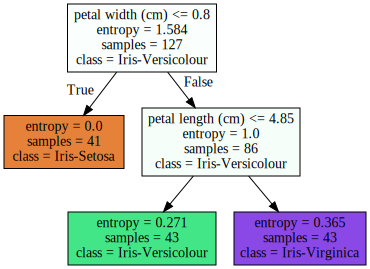

In [5]:
import graphviz, re, pydotplus
dot = tree.export_graphviz(model, feature_names=iris.feature_names, 
                           class_names=['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica'],
                           filled=True, impurity=True)
dot = re.sub('(\\\\nvalue = \[[0-9]+, [0-9]+, [0-9]+\])', '', dot)
dot = re.sub('(\\\\nvalue = \[[0-9]+, [0-9]+, [0-9]+\])\\\\n', '', dot)

graphviz.Source(dot, format="png")

In [6]:
n = Xtrn.shape[0]   # Number of training examples
print(model.tree_.weighted_n_node_samples)   # Training examples in each node
print(model.tree_.impurity)   # Impurity of each node
print(n)

[127.  41.  86.  43.  43.]
[1.58433858 0.         0.99960984 0.27138959 0.36505519]
127


In [7]:
# Compute feature importances by hand
w = model.tree_.weighted_n_node_samples
e = model.tree_.impurity
s = w * e
print(s)
v = np.array([s[0] - (s[1] + s[2]), s[2] - (s[3] + s[4])])
print(v)
v /= np.sum(v)
print(v)

[201.21100005   0.          85.96644593  11.66975226  15.69737315]
[115.24455413  58.59932051]
[0.66291984 0.33708016]


In [8]:
# Compare with feature importances computed by scikit-learn
model.feature_importances_

array([0.        , 0.        , 0.33708016, 0.66291984])

In [9]:
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('./figures/CH09_F03_Kunapuli.png');

A nice property of decision trees is that each path from root node to leaf node represents a decision rule. At every split, since an example can either go left or right only, the example can only end up at one of the three leaf nodes. 
This means that each leaf node (and by extension, each path from root to leaf, that is each rule) partitions the overall population into a sub-population. Let’s actually see this in action.
Since there are three leaf nodes, there are three decision rules, which we can write in Python syntax to understand them easier:

```
if petal_width <= 0.8: 
    class = ‘Iris-Setosa’
elif (petal_width > 0.8) and (petal_length <= 4.85):
    class = ‘Iris-Versicolour’
elif (petal_width > 0.8] and (petal_length > 4.85):
    class = ‘Iris-Virginica’
else:
	‘Can never reach here’
```

---
## 9.1.2. Generalized Linear Models
We now revisit generalized linear models (GLMs), which were originally introduced in Section 7.1.4.   Recall that generalized linear models extend linear models through a (nonlinear) link function, $g(y)$. For example, linear regression uses the identity link to relate the regression values y to the data x:

\\[
y= β_0+β_1 x_1+⋯+β_d x_d.
\\]

Here, the data point $x=[x_1,⋯,x_d]'$ is described by $d$ features, and the linear model is parameterized by the linear coefficients $β_1,⋯,β_d$ and the intercept (sometimes called the bias) $β_0$. Another example of a GLM is logistic regression, which uses the logit link to relate class probabilities p to the data x:

\\[
\ln⁡{\frac{p(y=1)}{1-p(y=1)}}= β_0+β_1 x_1+⋯+β_d x_d.
\\]

Generalized linear models are interpretable due to their linear and additive structure. The linear parameters themselves gives us an intuitive sense of each feature’s contribution to the overall prediction. The additive structure ensures that the overall prediction depends on the individual contributions from each feature.

The listing below loads the data set, trains a logistic regression classifier, and visualizes the increase or decrease in the odds of a positive breast cancer diagnosis of each feature. 

**Listing 9.2.** Training and interpreting logistic regression

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

bc = load_breast_cancer()
X, y = StandardScaler().fit_transform(bc.data), bc.target

Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.15)
model = LogisticRegression(max_iter=1000, solver='saga', penalty='l1')
model.fit(Xtrn, ytrn)
ypred = model.predict(Xtst)
print('Accuracy = {0:5.3}%'.format(accuracy_score(ytst, ypred) * 100))

Accuracy =  96.5%


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


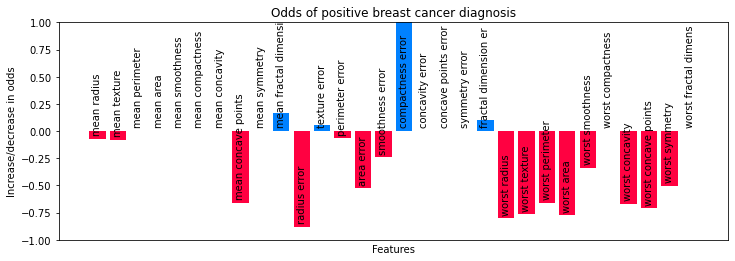

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))

odds = np.exp(model.coef_[0]) - 1.   # Subtract from 1.0, to determine how much the odds increase or decrease
colors = np.full(odds.shape, fill_value='#0081ff')
colors[model.coef_[0] < 0] = '#ff0141'
ax.bar(height=odds, x=np.arange(0, Xtrn.shape[1]), color=colors)
for i, feature in enumerate(bc.feature_names):
    j = (odds[i] < 0) * odds[i] 
    ax.text(i-0.25, j+0.05, feature[:20], rotation=90)
plt.title('Odds of positive breast cancer diagnosis')
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Increase/decrease in odds')
plt.ylim([-1., 1.])

pngFile = './figures/CH09_F05_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)